# Introduction

I want to see if a multidimensional linear regression model could be helpful in determining the ranked preferences of Iowa voters particpating in the Democratic caucuses.

Since we don't have historic data, I'm first going to generate fake data from a number of voter archetypes with set expectations. Then, we'll run a regression model to see if those expectations are reflected in the data.

# The precincts
Iowa has 99 counties. But the real jurisdictions that matter are the caucus sites. This is where voting happens.

Let's first come up with initial random vote distributions for all of Iowa's 1,689 voting precincts. For the sake of argument, let's say they're all the same size (1,000 voters) and have the same voting power, though in real life precincts range in size from around 100 people to more than 5,000.

We'll make these random distributions using a [Dirichlet distribution.](https://en.wikipedia.org/wiki/Dirichlet_distribution). I'll admit I don't really get the math, but using Numpy, you can give a list of expected frequencies and `numpy.random.dirichlet` will generate `n` sets of frequencies that will vary individually but average out to the supplied means.

So we'll use the function to generate 1,689 sets of voting percentages for Biden, Buttigieg, Klobuchar, Sanders, Warren and Yang, with their current statewide polling as a base.

In [1]:
import numpy

statewideStats = {
    "Biden": 0.23,
    "Buttigieg": 0.24,
    "Klobuchar": .09,
    "Sanders": .23,
    "Warren": .16,
    "Yang": .05   
}

rawData = numpy.random.dirichlet((list(map(lambda c: c * 100, statewideStats.values()))), 1689)
precincts = []
for row in rawData:
    precinct = {
        "voters": [],
        "firstRoundRaw": {},
        "firstRoundPercentage": {}
    }
    for index, candidate in enumerate(statewideStats.keys()):
        voterCount = int(round(row[index] * 1000))
        precinct["firstRoundRaw"][candidate] = voterCount
        precinct["firstRoundPercentage"][candidate] = row[index]
        precinct["voters"] += [candidate] * voterCount
    precincts.append(precinct)

# Voter behavior

OK! With our dataset in hand, it's now time to enter _simulation mode._

At each caucus site, there are two rounds of voting. After the first, caucusers are allowed to change their mind after seeing how everyone else has voted. At the end of the second round, any candidate with less than 15 percent of a caucus site's vote gets eliminated, and their votes are discarded. 

So it's in a caucuser's best interest to switch sides if their candidate doesn't hit 15 percent in the first round. That is, unless they _really_ believe in them. 

First, let's build out our archetypes. We'll assume there are five candidates:

* Joe Biden
* Elizabeth Warren
* Pete Buttigieg
* Bernie Sanders
* Any Klobuchar
* Andrew Yang

Each candidates supporters have different preferences for other candiates, if their candidate loses viability in the caucus:

* Biden
    * 50% will stay no matter what
    * 25% will go to Buttigieg
    * 10% will go to Klobuchar
    * 10% will go to Warren
    * 5% will go to the rest
    
* Warren
    * 60% will stay no matter what
    * 30% will go to Sanders
    * 10% will go to the rest
    
* Buttigieg
    * 30% will stay no matter what
    * 50% will go to Biden
    * 20% will go to the rest
    
* Sanders
    * 80% will stay no matter what
    * 15% will go to Warren
    * 5% will go to the rest
    
* Klobuchar
    * 10% will stay no matter what
    * 90% will go to the rest
    
* Andrew Yang
    * 90% will stay no matter what
    * 10% will go to the rest


In [2]:
candidates = {'Biden': {'Biden': 0.5, 'Buttigieg': 0.25, 'Klobuchar': 0.1, 'Sanders': 0.025, 'Warren': 0.1, 'Yang': 0.025}, 'Warren': {'Biden': 0.025, 'Buttigieg': 0.025, 'Klobuchar': 0.025, 'Sanders': 0.3, 'Warren': 0.6, 'Yang': 0.025}, 'Buttigieg': {'Biden': 0.5, 'Buttigieg': 0.3, 'Klobuchar': 0.05, 'Sanders': 0.05, 'Warren': 0.05, 'Yang': 0.05}, 'Sanders': {'Biden': 0.0125, 'Buttigieg': 0.0125, 'Klobuchar': 0.0125, 'Sanders': 0.8, 'Warren': 0.15, 'Yang': 0.0125}, 'Klobuchar': {'Biden': 0.18, 'Buttigieg': 0.18, 'Klobuchar': 0.1, 'Sanders': 0.18, 'Warren': 0.18, 'Yang': 0.18}, 'Yang': {'Biden': 0.02, 'Buttigieg': 0.02, 'Klobuchar': 0.02, 'Sanders': 0.02, 'Warren': 0.02, 'Yang': 0.9}}

Let's now run the simulation. Here's how it'll work:

* We'll assume the existing stats represent the first round of voting. 
* We'll run voter by voter in each precinct. 
 * If their candidate is above 15 percent, they'll stand pat.
 * If their candidate is below 15 percent, they may or may not switch sides, depending on the probabilities of their voter type.
 
After we determine the results of the second round of voting, we'll calculate the delta in percentage points, per candidate, between the first and second rounds.

In [3]:
for precinct in precincts:
    precinct["secondRoundRaw"] = {
        "Biden": 0,
        "Buttigieg": 0,
        "Klobuchar": 0,
        "Sanders": 0,
        "Warren": 0,
        "Yang": 0
    }
    
    for voter in precinct["voters"]:
        if precinct["firstRoundPercentage"][voter] >= .15:
            precinct["secondRoundRaw"][voter] += 1
        else:
            archetype = candidates[voter]
            choice = numpy.random.choice(list(archetype.keys()), p=list(archetype.values()))
            precinct["secondRoundRaw"][choice] += 1
    
    precinct["secondRoundPercentage"] = {}
    precinct["delta"] = {}
    for candidate in precinct["secondRoundRaw"].keys():
        precinct["secondRoundPercentage"][candidate] = precinct["secondRoundRaw"][candidate] / len(precinct["voters"])
        precinct["delta"][candidate] = (precinct["secondRoundPercentage"][candidate] - precinct["firstRoundPercentage"][candidate]) * 100

Now that we've calculated the percentage of votes cast for the second round of caucusing, let's calculate the delta for each.



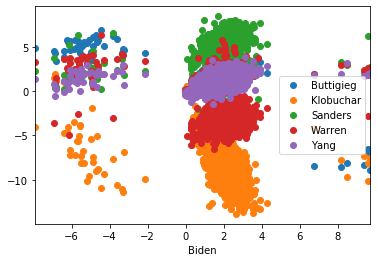

                            OLS Regression Results                            
Dep. Variable:                  Biden   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.559e+30
Date:                Fri, 27 Dec 2019   Prob (F-statistic):               0.00
Time:                        09:49:42   Log-Likelihood:                 51970.
No. Observations:                1689   AIC:                        -1.039e+05
Df Residuals:                    1683   BIC:                        -1.039e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.732e-15   8.33e-16      2.079      0.0

In [18]:
from sklearn.linear_model import LinearRegression
from pandas import DataFrame
import statsmodels.api as sm
import matplotlib.pyplot as plt 

delta_data = map(lambda p: p["delta"],precincts)

# Let's try Biden first
data = DataFrame(delta_data)

X = data[['Buttigieg', 'Klobuchar', 'Sanders', 'Warren', 'Yang']]
Y = data['Biden']

data.plot(x='Biden' style='o')
plt.show()

X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
print_model = model.summary()
print(print_model)